In [1]:
from time import time

import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Bidirectional, Reshape, TimeDistributed
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.layers import *
from keras.models import *
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from cv2 import *
import os
import random
import warnings
warnings.filterwarnings('ignore')
tf.config.list_physical_devices('GPU')

[]

# Data Loading #

In [2]:
path = "C:/archive/UTKFace/utkface_aligned_cropped/UTKFace"
files = os.listdir(path)

# Randomise files
random.seed(42)
random.shuffle(files)

size = 10000
# size = len(files)
files = files[:size]
print('Samples: ', size)

Samples:  10000


In [3]:
images = []
ages = []
for file in files:
    image = cv2.imread(os.path.join(path, file), 0)
    image = cv2.resize(image, dsize=(64, 64))
    image = image.reshape((image.shape[0], image.shape[1], 1))
    images.append(image)
    split_var = file.split('_')
    ages.append(int(split_var[0]))

# Data Analysis #

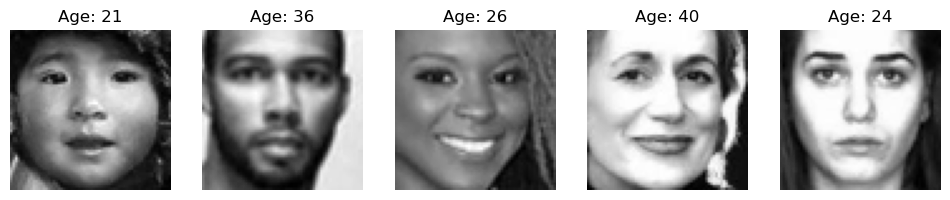

In [4]:
# Define the number of images to display
num_images_to_display = 5

# Create subplots for displaying images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(12, 3))

# Loop through and display the images
for i in range(num_images_to_display):
    ax = axes[i]
    ax.imshow(images[i][:, :, 0], cmap='gray')
    ax.set_title(f"Age: {ages[i]}")
    ax.axis('off')

plt.show()

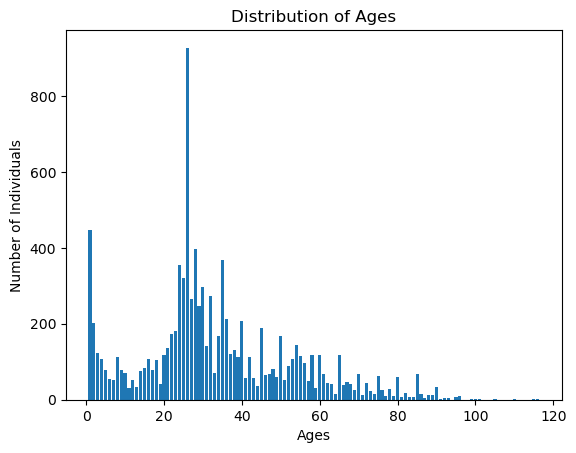

Max age: 116, Minimum age: 1, Average age: 33.4267


In [5]:
x_ages = list(set(ages))
y_ages = [ages.count(i) for i in x_ages]

plt.bar(x_ages, y_ages)
plt.xlabel('Ages')
plt.ylabel('Number of Individuals')
plt.title('Distribution of Ages')
plt.show()

max_age = max(ages)
min_age = min(ages)
average_age = sum(ages) / len(ages)

print(f'Max age: {max_age}, Minimum age: {min_age}, Average age: {average_age}')


Age: 54


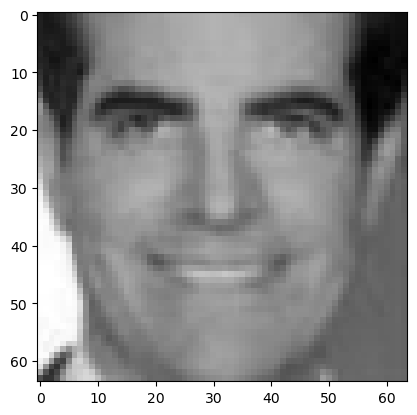

In [6]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
idx = 500
sample = images[idx]
print('Age:', ages[idx])
display(sample)

# Data Preprocessing #

In [7]:
def age_group(age):
    if age >=1 and age < 2:
        return 1
    elif age < 6:
        return 2
    elif age < 13:
        return 3
    elif age < 18:
        return 4
    elif age < 25:
        return 5
    elif age < 45:
        return 6
    elif age < 66:
        return 7
    else:
        return 8

In [8]:
target = np.zeros((size, 1), dtype='float32')
features = np.zeros((size, sample.shape[0], sample.shape[1], 1), dtype='float32')
for i in range(size):
    target[i] = age_group(ages[i]) - 1  # Age groups starting from 0 for classification
    features[i] = images[i]
features = features / 255

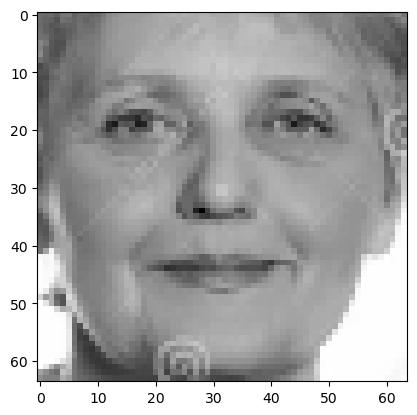

None 
 [7.]


In [9]:
print(display(features[550]), '\n', target[550])

# Data Splitting #
70% Training
20% Validation
10% Testing

In [10]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, shuffle = True)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.66, shuffle = True)

# Data Splitting #
80% Training
10% Validation
10% Testing

In [11]:
# x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle = True)
# x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, shuffle = True)

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

train_datagen.fit(x_train)

val_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

train_datagen.fit(x_val)

In [13]:
print('Training samples:', x_train.shape[0])
print('Validation samples:', x_val.shape[0])
print('Test samples:', x_test.shape[0], '\n')
print('Image shape:', sample.shape)

Training samples: 7000
Validation samples: 1980
Test samples: 1020 

Image shape: (64, 64, 1)


# Model Training #

In [14]:
# File path to save/load the model
model_file_path = "model_cnn.h5"

if os.path.exists(model_file_path):
    print("Model exists. Loading the existing model...")
    model = keras.models.load_model(model_file_path)

else:
    # Model Training #
    print("Model does not exist. Training the model...")
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-4)
    
    t0 = time()
    training_process = model.fit(x_train, 
                            y_train, 
                            epochs=25, 
                            validation_data=(x_val, y_val), 
                            batch_size=16, 
                            shuffle=True,
                            callbacks=[reduce_lr])
    print("done in %0.3fs" % (time() - t0))
    history = training_process
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('70-20-10 CNN Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Training', 'Validation'], loc = 'upper left')
    plt.show()
    model.save("model_cnn.h5")

Model exists. Loading the existing model...


In [15]:
print(model.evaluate(x_train,y_train))
print(model.evaluate(x_val,y_val))
print(model.evaluate(x_test,y_test))

219/219 [==============================] - 12s 51ms/step - loss: 0.7823 - accuracy: 0.7134
[0.7823265790939331, 0.7134285569190979]
62/62 [==============================] - 3s 53ms/step - loss: 0.8603 - accuracy: 0.7081
[0.8603197932243347, 0.7080808281898499]
32/32 [==============================] - 2s 60ms/step - loss: 0.7739 - accuracy: 0.7118
[0.7739254832267761, 0.7117646932601929]


# Model Testing #

1/1 [==============================] - 0s 23ms/step


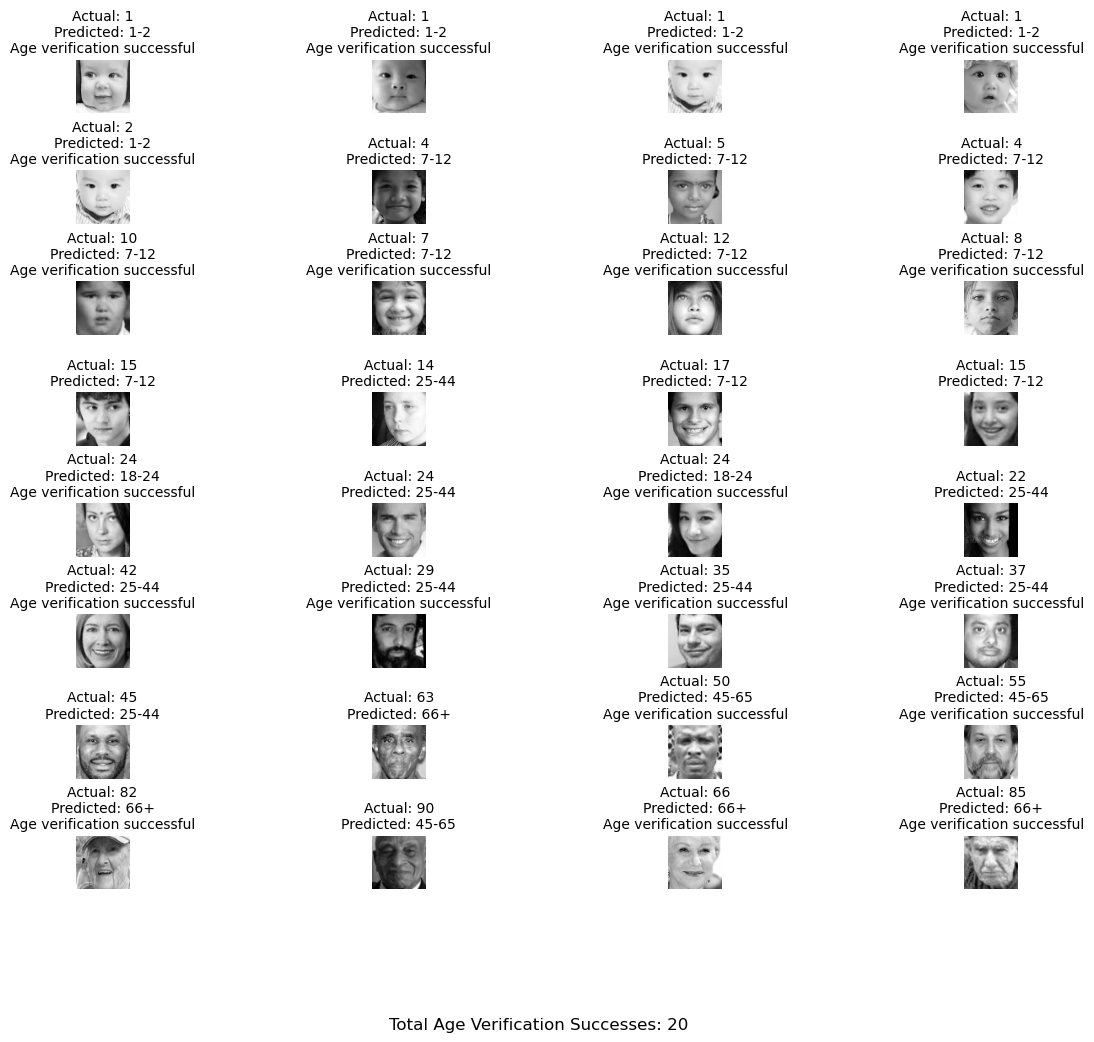

In [16]:
def display_images_with_age(images, ages, model, indexes):
    age_ranges = {
        "1-2": (1, 2),
        "2-6": (2, 6.99),
        "7-12": (7, 12.99),
        "13-17": (13, 17.99),
        "18-24": (18, 24.99),
        "25-44": (25, 44.99),
        "45-65": (45, 65.99),
        "66+": (66, 120)  # Adjust the upper bound as needed
    }

    num_cols = 4
    num_rows = len(indexes) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))
    fig.tight_layout(h_pad=2)
    
    success_count = 0  # Count of successful age verifications
    
    for i, ax in enumerate(axes.flat):
        if i < len(indexes):
            sample = images[indexes[i]]
            actual_age = ages[indexes[i]]
            
            ax.imshow(sample[:, :, 0], cmap='gray')
            ax.axis('off')
            
            sample_normalized = sample / 255
            val = model.predict(np.array([sample_normalized]))
            age_group = val.argmax()
            predicted_age = list(age_ranges.keys())[age_group]
            
            title = f"Actual: {actual_age}\nPredicted: {predicted_age}"
            if age_ranges[predicted_age][0] <= actual_age <= age_ranges[predicted_age][1]:
                title += "\nAge verification successful"
                success_count += 1
            
            ax.set_title(title, fontsize=10, pad=5)
        else:
            fig.delaxes(ax)  # Remove empty subplots if there are extra spaces
    
    # Add a text annotation at the bottom with the total count of successful verifications
    plt.text(0.5, 0.01, f"Total Age Verification Successes: {success_count}",
             ha='center', fontsize=12, transform=fig.transFigure)
    
    plt.show()


indexes = [6963, 7292, 2400, 4109, 65, 8867, 5837, 7792, 9181, 6814, 3866, 676, 3736, 7108, 4947, 2212, 7620, 4511, 6569, 9517, 9585, 498, 4240, 9827, 513, 7340, 9225, 2783, 4615, 8337, 8456, 5456]
display_images_with_age(images, ages, model, indexes)

# Federated Learning Simulation #

In [17]:
# File path to save/load the model
federated_model_path = "federated_model_cnn.h5"

if os.path.exists(federated_model_path):
    print("Model exists. Loading the existing model...")
    fed_cnn = keras.models.load_model(federated_model_path)

else:
    #Client Files
    client1_files = os.listdir(path)
    client2_files = os.listdir(path)

    # Randomise files
    random.seed(6)
    random.shuffle(client1_files)

    random.seed(9)
    random.shuffle(client2_files)


    size = 5000
    # size = len(files)
    client1_files = client1_files[:size]
    client2_files = client2_files[:size]
    print('Client 1 Samples: ', size)
    print('Client 2 Samples: ', size)

    # Load data for each client
    client1_images = []
    client1_ages = []
    for file in client1_files:
        image = cv2.imread(os.path.join(path, file), 0)
        image = cv2.resize(image, dsize=(64, 64))
        image = image.reshape((image.shape[0], image.shape[1], 1))
        client1_images.append(image)
        split_var = file.split('_')
        client1_ages.append(int(split_var[0]))

    client2_images = []
    client2_ages = []
    for file in client2_files:
        image = cv2.imread(os.path.join(path, file), 0)
        image = cv2.resize(image, dsize=(64, 64))
        image = image.reshape((image.shape[0], image.shape[1], 1))
        client2_images.append(image)
        split_var = file.split('_')
        client2_ages.append(int(split_var[0]))

    # Data Preprocessing for each client
    client1_target = np.zeros((len(client1_ages), 1), dtype='float32')
    client1_features = np.zeros((len(client1_images), client1_images[0].shape[0], client1_images[0].shape[1], 1), dtype='float32')
    for i in range(len(client1_ages)):
        client1_target[i] = age_group(client1_ages[i]) - 1  # Age groups starting from 0 for classification
        client1_features[i] = client1_images[i]
    client1_features = client1_features / 255

    client2_target = np.zeros((len(client2_ages), 1), dtype='float32')
    client2_features = np.zeros((len(client2_images), client2_images[0].shape[0], client2_images[0].shape[1], 1), dtype='float32')
    for i in range(len(client2_ages)):
        client2_target[i] = age_group(client2_ages[i]) - 1  # Age groups starting from 0 for classification
        client2_features[i] = client2_images[i]
    client2_features = client2_features / 255

    # Create model instances for each client
    client1_model = keras.models.clone_model(model)
    client1_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    client2_model = keras.models.clone_model(model)
    client2_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Federated Learning Rounds
    num_rounds = 5

    for round_num in range(num_rounds):
        print(f"Federated Learning - Round {round_num + 1}/{num_rounds}")

        # Client 1 Training
        client1_model.set_weights(model.get_weights())
        t1 = time()
        client1_model.fit(client1_features, client1_target, epochs=5, batch_size=16)
        print("done in %0.3fs" % (time() - t1))

        # Client 2 Training
        client2_model.set_weights(model.get_weights())
        t2 = time()
        client2_model.fit(client2_features, client2_target, epochs=5, batch_size=16)
        print("done in %0.3fs" % (time() - t2))

        # Aggregate model updates
        client1_weights = client1_model.get_weights()
        client2_weights = client2_model.get_weights()

        updated_weights = [(w1 + w2) / 2 for w1, w2 in zip(client1_weights, client2_weights)]
        model.set_weights(updated_weights)
        
        # Save the final aggregated model
        model.save("federated_model_cnn.h5")

Model exists. Loading the existing model...


# Federated Learning Model Testing #

In [18]:
fed_cnn = tf.keras.models.load_model('federated_model_cnn.h5')

In [19]:
fed_cnn.evaluate(x_test,y_test)

32/32 [==============================] - 2s 50ms/step - loss: 0.7076 - accuracy: 0.7078


[0.7075841426849365, 0.7078431248664856]

1/1 [==============================] - 0s 25ms/step


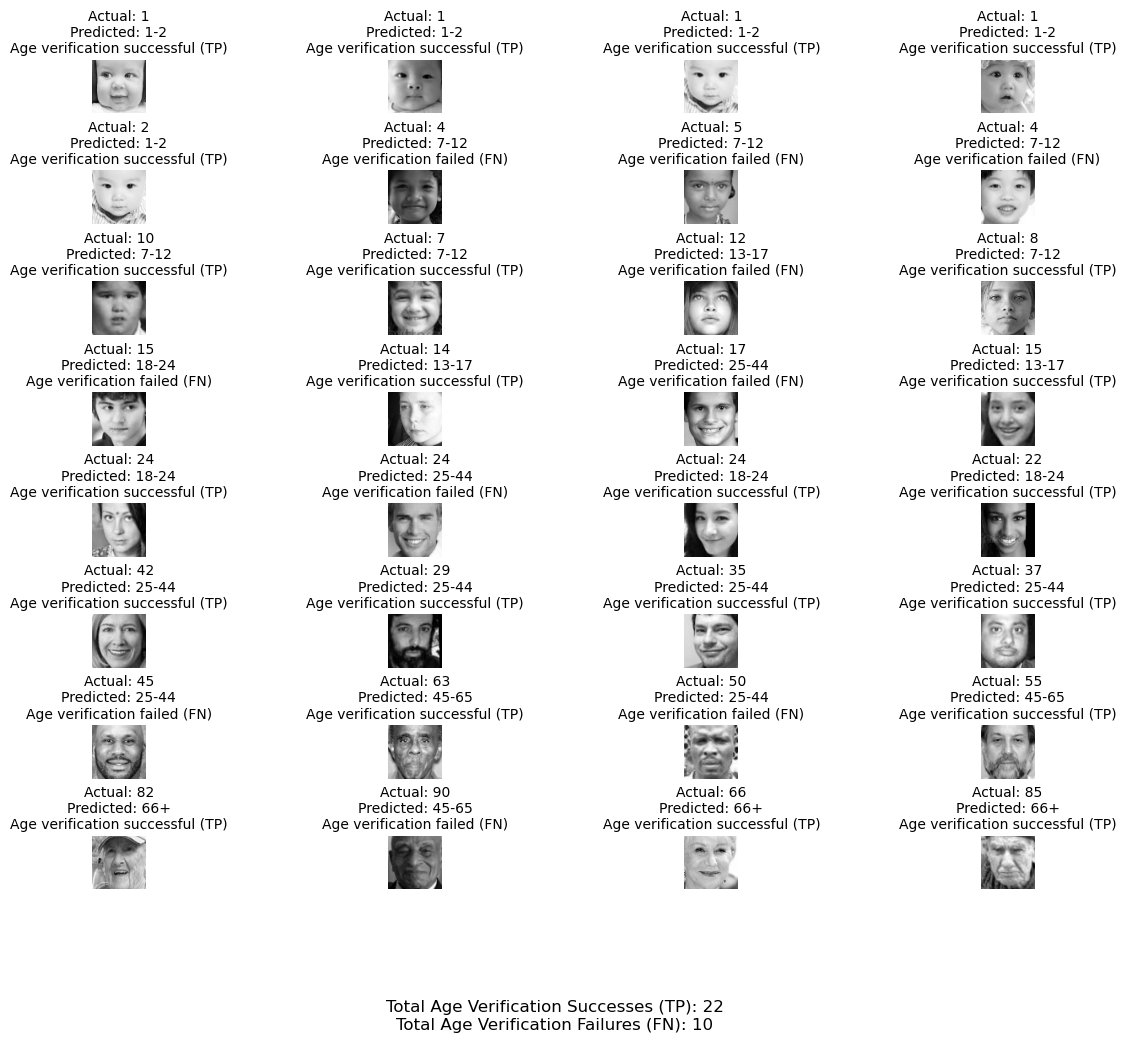

In [20]:
def display_images_with_age(images, ages, model, indexes):
    age_ranges = {
        "1-2": (1, 2),
        "2-6": (2, 6.99),
        "7-12": (7, 12.99),
        "13-17": (13, 17.99),
        "18-24": (18, 24.99),
        "25-44": (25, 44.99),
        "45-65": (45, 65.99),
        "66+": (66, 120)  # Adjust the upper bound as needed
    }

    num_cols = 4
    num_rows = len(indexes) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))
    fig.tight_layout(h_pad=2)

    success_count = 0  # Count of successful age verifications
    tp_count = 0  # Count of True Positives
    tn_count = 0  # Count of True Negatives
    fp_count = 0  # Count of False Positives
    fn_count = 0  # Count of False Negatives

    for i, ax in enumerate(axes.flat):
        if i < len(indexes):
            sample = images[indexes[i]]
            actual_age = ages[indexes[i]]

            ax.imshow(sample[:, :, 0], cmap='gray')
            ax.axis('off')

            sample_normalized = sample / 255
            val = model.predict(np.array([sample_normalized]))
            age_group = val.argmax()
            predicted_age = list(age_ranges.keys())[age_group]

            if age_ranges[predicted_age][0] <= actual_age <= age_ranges[predicted_age][1]:
                title = f"Actual: {actual_age}\nPredicted: {predicted_age}\nAge verification successful (TP)"
                tp_count += 1
            else:
                title = f"Actual: {actual_age}\nPredicted: {predicted_age}\nAge verification failed (FN)"
                fn_count += 1

            ax.set_title(title, fontsize=10, pad=5)
        else:
            fig.delaxes(ax)  # Remove empty subplots if there are extra spaces

    # Add a text annotation at the bottom with the counts
    plt.text(0.5, 0.01, f"Total Age Verification Successes (TP): {tp_count}\nTotal Age Verification Failures (FN): {fn_count}",
             ha='center', fontsize=12, transform=fig.transFigure)

    plt.show()

indexes = [6963, 7292, 2400, 4109, 65, 8867, 5837, 7792, 9181, 6814, 3866, 676, 3736, 7108, 4947, 2212, 7620, 4511, 6569, 9517, 9585, 498, 4240, 9827, 513, 7340, 9225, 2783, 4615, 8337, 8456, 5456]
display_images_with_age(images, ages, fed_cnn, indexes)


In [27]:
def calculate_age_verification_metrics(images, ages, model):
    age_ranges = {
        "1-2": (1, 2),
        "2-6": (2, 6.99),
        "7-12": (7, 12.99),
        "13-17": (13, 17.99),
        "18-24": (18, 24.99),
        "25-44": (25, 44.99),
        "45-65": (45, 65.99),
        "66+": (66, 120)  # Adjust the upper bound as needed
    }

    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for i in range(len(ages)):
        sample = images[i]
        actual_age = ages[i]

        sample_normalized = sample / 255
        val = model.predict(np.array([sample_normalized]))
        age_group = val.argmax()
        predicted_age = list(age_ranges.keys())[age_group]

        if age_ranges[predicted_age][0] <= actual_age <= age_ranges[predicted_age][1]:
            if age_group == actual_age - 1:
                TP += 1
            else:
                FN += 1
        else:
            if age_group == actual_age - 1:
                FP += 1
            else:
                TN += 1

    return TP, TN, FP, FN

# Calculate TP, TN, FP, FN for your CNN model's age verification
TP, TN, FP, FN = calculate_age_verification_metrics(x_test, y_test, fed_cnn)

print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)


1/1 [==============================] - 0s 27ms/step
True Positives: 0
True Negatives: 830
False Positives: 190
False Negatives: 0
